In [52]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

datetime_features = ['dayofweek', 'month', 'hour', 'minute', 'is_weekend']

def get_masked_data(df: pd.DataFrame):
    start_timestamp = pd.to_datetime('2023-01-01 01:00:00')
    end_timestamp = pd.to_datetime('2023-12-31 23:00:00')

    # Create a boolean mask for the specified time range
    mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    df = df[mask]
    df.fillna(0, inplace=True)
    df.sort_values(by='timestamp', inplace=True)
def to_input(df: pd.DataFrame):
    df['precipitation'].fillna(0, inplace=True)

    return df

df = pd.read_parquet("../data/rucphen_precipitation.parquet")
df.rename(columns={'polygon_1663': 'precipitation'}, inplace=True)
df = to_input(df)

X = df[['timestamp', 'precipitation']]
y = df['percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=False)

# X_scaler = StandardScaler()
# X_train['precipitation'] = X_scaler.fit_transform(X_train['precipitation'].values.reshape(-1, 1))
# X_test['precipitation'] = X_scaler.transform(X_test['precipitation'].values.reshape(-1, 1))

# y_scaler = StandardScaler()
# y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
# y_test = y_scaler.transform(y_test.values.reshape(-1, 1))

# Reshape the precipitation column
exog_values = X_train['precipitation'].values.reshape(-1, 1)

# Fit ARIMA model with exogenous variables
order = (1, 1, 3)  # Specify the order of the ARIMA model
model = SARIMAX(y_train, order=order, exog=exog_values)
result = model.fit(disp=False)

In [70]:
df.head()

,timestamp,precipitation,percentage
0,2023-01-01 00:00:00,0.01001,11.404
1,2023-01-01 00:05:00,0.01000,11.302
2,2023-01-01 00:10:00,0.00000,11.010
3,2023-01-01 00:15:00,0.00000,10.718
4,2023-01-01 00:20:00,0.00000,10.326


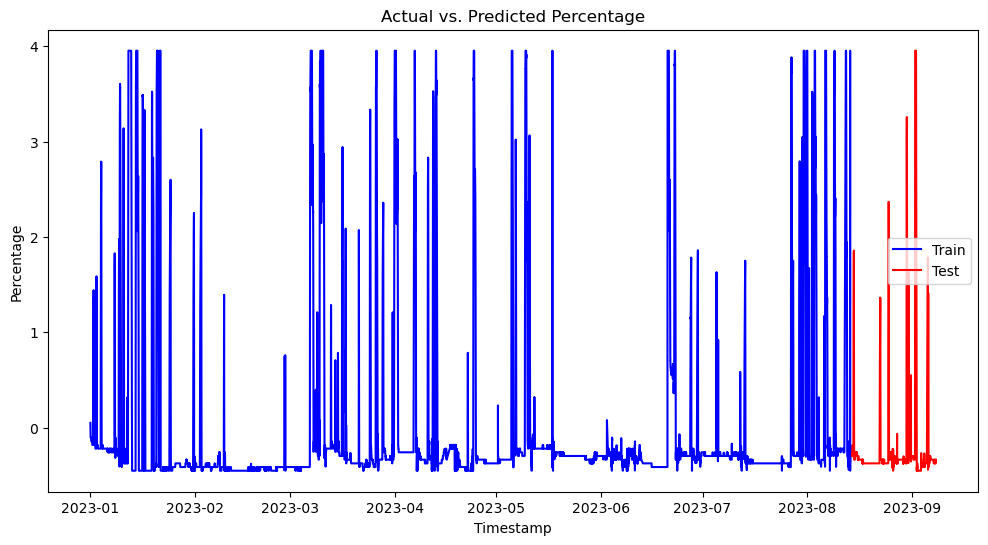

In [53]:
# Plot train and testdata
plt.figure(figsize=(12, 6))
plt.plot(X_train['timestamp'], y_train, label='Train', color='blue')
plt.plot(X_test['timestamp'], y_test, label='Test', color='red')

# Fill the area between the confidence intervals
# plt.fill_between(y_test.index, confidence_intervals['lower percentage'], confidence_intervals['upper percentage'], color='pink', alpha=0.3, label='Confidence Intervals')

plt.title('Actual vs. Predicted Percentage')
plt.xlabel('Timestamp')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [65]:


# Get the forecast for the test set
forecast = result.get_forecast(steps=len(X_train), exog=X_train['precipitation'].values.reshape(-1, 1))

In [66]:
forecast.predicted_mean

array([-0.29766327, -0.2976634 , -0.29779889, ..., -0.29779889,
       -0.29779889, -0.29779889])

In [67]:
len(forecast.predicted_mean) == len(X_test['precipitation'])

False

In [68]:
# forecast.predicted_mean.plot()

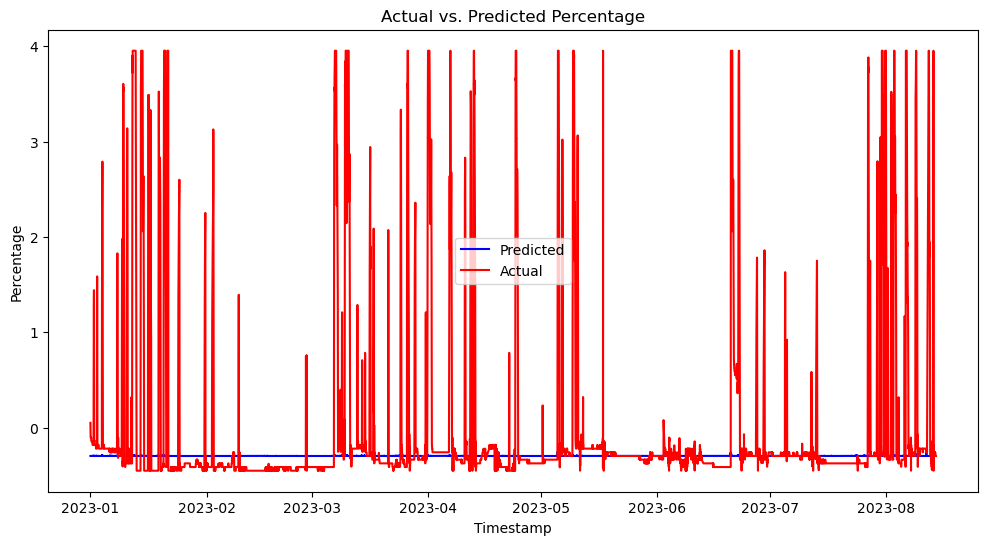

In [69]:
# Extract the predicted values and confidence intervals
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(X_train['timestamp'], forecast.predicted_mean, label='Predicted', color='blue')
plt.plot(X_train['timestamp'], y_train, label='Actual', color='red')

# Fill the area between the confidence intervals
# plt.fill_between(y_test.index, confidence_intervals['lower percentage'], confidence_intervals['upper percentage'], color='pink', alpha=0.3, label='Confidence Intervals')

plt.title('Actual vs. Predicted Percentage')
plt.xlabel('Timestamp')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [ ]:
result.plot_diagnostics(figsize=(12, 8))
plt.show()